Data Load and Initial Setup

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚢 TITANIC SURVIVAL PREDICTION - COMPLETE PIPELINE")
print("="*60)

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission_data = pd.read_csv('gender_submission.csv')


print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

print("\n📊 Quick Data Overview:")
print(f"Survival rate: {train_data['Survived'].mean():.2%}")
print(f"Missing values in Age: {train_data['Age'].isnull().sum()}")
print(f"Missing values in Embarked: {train_data['Embarked'].isnull().sum()}")

train_processed = train_data.copy()
test_processed = test_data.copy()

all_data = [train_processed, test_processed]

for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone']= (dataset['FamilySize'] == 1).astype(int)

    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                               'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in all_data:
    for title in dataset['Title'].unique():
        if pd.isna(title):
            continue
        for pclass in dataset['Pclass'].unique():
            mask = (dataset['Title'] == title) & (dataset['Pclass'] == pclass)
            median_age = dataset.loc[mask, 'Age'].median()
            if pd.isna(median_age):
                median_age = dataset['Age'].median()
            dataset.loc[mask & dataset['Age'].isna(), 'Age'] = median_age

embarked_mode = train_processed['Embarked'].mode()[0]
for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].fillna(embarked_mode)
    dataset['Fare'] = dataset['Fare'].fillna(dataset.groupby('Pclass')['Fare'].transform('median'))

for dataset in all_data:
    dataset['AgeGroup'] = pd.cut(dataset['Age'], bins=[0, 12, 18, 35, 60, 100],
                               labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    dataset['FareGroup'] = pd.qcut(dataset['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

categorical_features = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    combined_feature = pd.concat([train_processed[feature], test_processed[feature]], axis=0)
    le.fit(combined_feature.astype(str))

    train_processed[feature] = le

🚢 TITANIC SURVIVAL PREDICTION - COMPLETE PIPELINE
✅ Data loaded successfully!
Training data shape: (891, 12)
Test data shape: (418, 11)

📊 Quick Data Overview:
Survival rate: 38.38%
Missing values in Age: 177
Missing values in Embarked: 2


Explaratory Data Analysis

EXPLORATORY DATA ANALYSIS

Dataset Overview:
Training data shape: (891, 12)
Test data shape: (418, 11)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Statistical Summary:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891

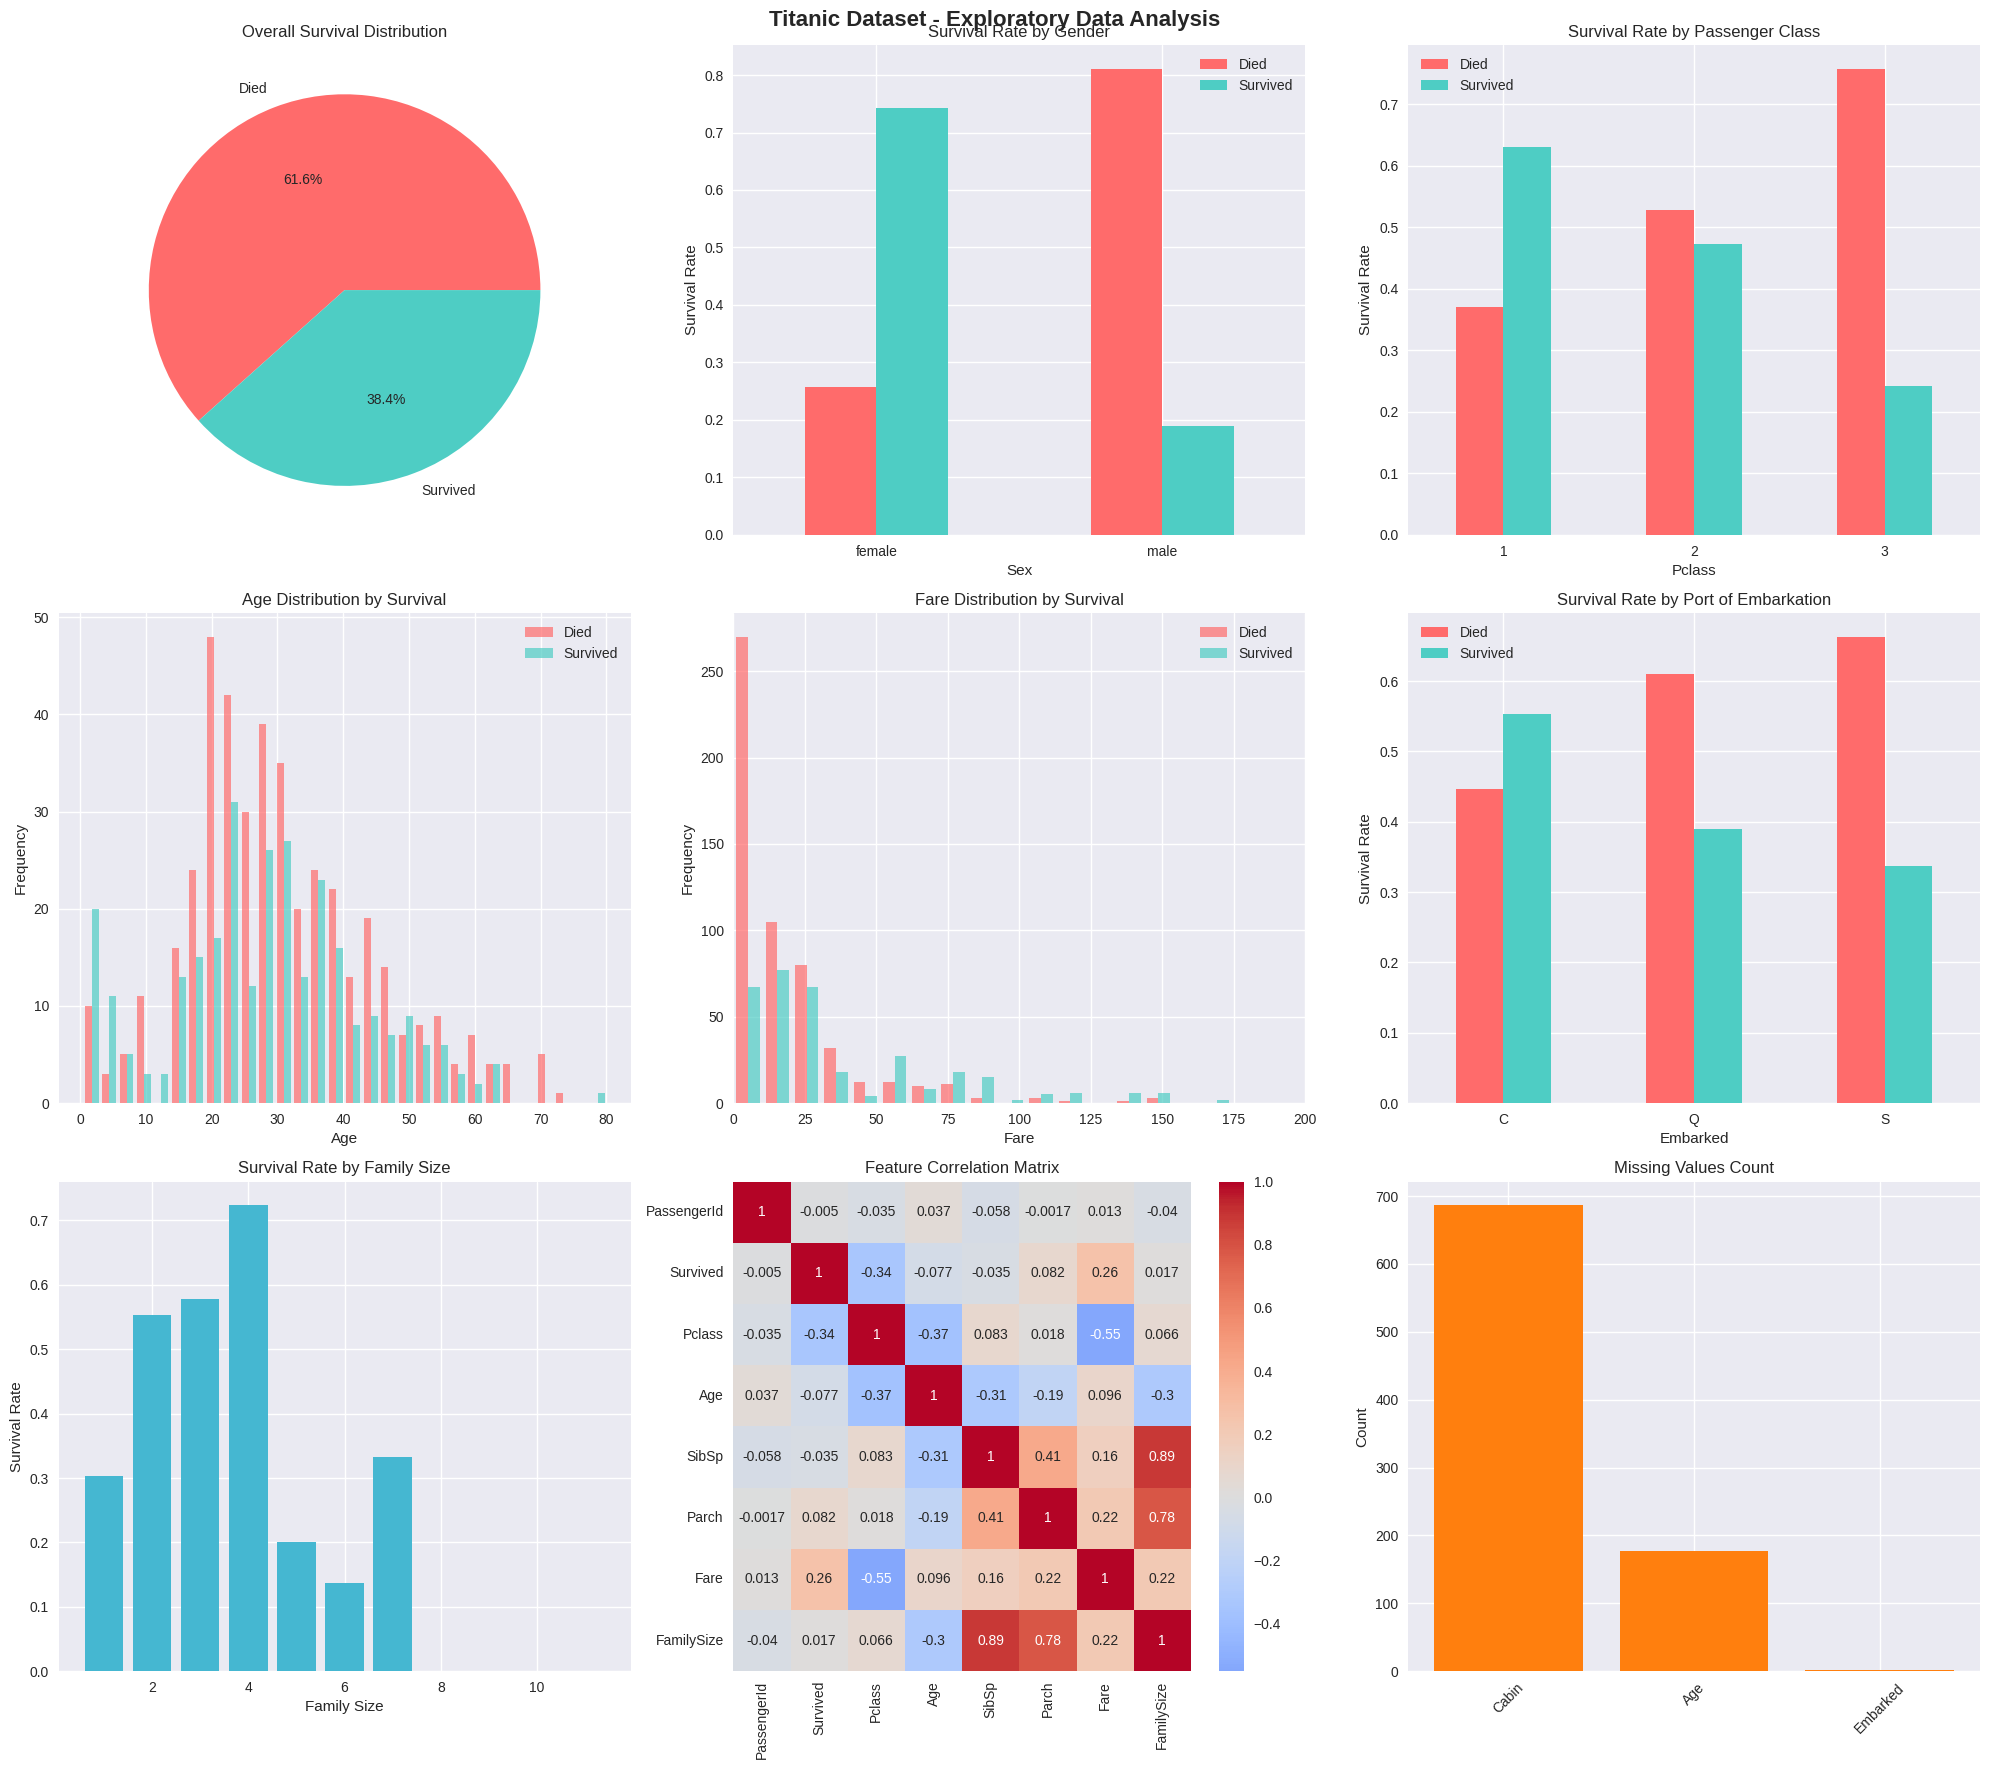

In [24]:
def explore_data(train_data, test_data):
    print("="*50)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*50)

    print("\nDataset Overview:")
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    print("\nTraining Data Info:")
    print(train_data.info())

    print("\nStatistical Summary:")
    print(train_data.describe())

    print("\nMissing Values Analysis:")
    missing_train = train_data.isnull().sum()
    missing_test = test_data.isnull().sum()

    missing_df = pd.DataFrame({
        'Train': missing_train,
        'Test': missing_test,
        'Train %': (missing_train / len(train_data)) * 100,
        'Test %': (missing_test / len(test_data)) * 100
    })
    print(missing_df[missing_df['Train'] > 0])

    print(f"\nOverall Survival Rate: {train_data['Survived'].mean():.2%}")

    return missing_df

def create_eda_plots(train_data):
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Titanic Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

    survival_counts = train_data['Survived'].value_counts()
    axes[0, 0].pie(survival_counts.values, labels=['Died', 'Survived'], autopct='%1.1f%%',
                   colors=['#ff6b6b', '#4ecdc4'])
    axes[0, 0].set_title('Overall Survival Distribution')

    survival_sex = pd.crosstab(train_data['Sex'], train_data['Survived'], normalize='index')
    survival_sex.plot(kind='bar', ax=axes[0, 1], color=['#ff6b6b', '#4ecdc4'])
    axes[0, 1].set_title('Survival Rate by Gender')
    axes[0, 1].set_ylabel('Survival Rate')
    axes[0, 1].legend(['Died', 'Survived'])
    axes[0, 1].tick_params(axis='x', rotation=0)

    survival_class = pd.crosstab(train_data['Pclass'], train_data['Survived'], normalize='index')
    survival_class.plot(kind='bar', ax=axes[0, 2], color=['#ff6b6b', '#4ecdc4'])
    axes[0, 2].set_title('Survival Rate by Passenger Class')
    axes[0, 2].set_ylabel('Survival Rate')
    axes[0, 2].legend(['Died', 'Survived'])
    axes[0, 2].tick_params(axis='x', rotation=0)

    axes[1, 0].hist([train_data[train_data['Survived']==0]['Age'].dropna(),
                    train_data[train_data['Survived']==1]['Age'].dropna()],
                   bins=30, alpha=0.7, label=['Died', 'Survived'], color=['#ff6b6b', '#4ecdc4'])
    axes[1, 0].set_title('Age Distribution by Survival')
    axes[1, 0].set_xlabel('Age')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()

    axes[1, 1].hist([train_data[train_data['Survived']==0]['Fare'].dropna(),
                    train_data[train_data['Survived']==1]['Fare'].dropna()],
                   bins=50, alpha=0.7, label=['Died', 'Survived'], color=['#ff6b6b', '#4ecdc4'])
    axes[1, 1].set_title('Fare Distribution by Survival')
    axes[1, 1].set_xlabel('Fare')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].set_xlim(0, 200)

    survival_embarked = pd.crosstab(train_data['Embarked'], train_data['Survived'], normalize='index')
    survival_embarked.plot(kind='bar', ax=axes[1, 2], color=['#ff6b6b', '#4ecdc4'])
    axes[1, 2].set_title('Survival Rate by Port of Embarkation')
    axes[1, 2].set_ylabel('Survival Rate')
    axes[1, 2].legend(['Died', 'Survived'])
    axes[1, 2].tick_params(axis='x', rotation=0)

    train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
    family_survival = train_data.groupby('FamilySize')['Survived'].mean()
    axes[2, 0].bar(family_survival.index, family_survival.values, color='#45b7d1')
    axes[2, 0].set_title('Survival Rate by Family Size')
    axes[2, 0].set_xlabel('Family Size')
    axes[2, 0].set_ylabel('Survival Rate')

    numeric_cols = train_data.select_dtypes(include=[np.number]).columns
    correlation_matrix = train_data[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[2, 1])
    axes[2, 1].set_title('Feature Correlation Matrix')

    missing_data = train_data.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
    axes[2, 2].bar(missing_data.index, missing_data.values, color='#ff7f0e')
    axes[2, 2].set_title('Missing Values Count')
    axes[2, 2].set_ylabel('Count')
    axes[2, 2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

missing_analysis = explore_data(train_data, test_data)
create_eda_plots(train_data)

Data preprocessing and feature engineering

In [25]:
def preprocess_data(train_data, test_data):
    print("="*50)
    print("DATA PREPROCESSING")
    print("="*50)

    train_processed = train_data.copy()
    test_processed = test_data.copy()

    all_data = [train_processed, test_processed]

    for dataset in all_data:
        print("Creating new features...")

        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
        dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype(int)

        dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                                   'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

        dataset['AgeGroup'] = pd.cut(dataset['Age'], bins=[0, 12, 18, 35, 60, 100],
                                   labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

        dataset['FareGroup'] = pd.qcut(dataset['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

    print("Handling missing values...")

    for dataset in all_data:
        for title in dataset['Title'].unique():
            if pd.isna(title):
                continue
            for pclass in dataset['Pclass'].unique():
                mask = (dataset['Title'] == title) & (dataset['Pclass'] == pclass)
                median_age = dataset.loc[mask, 'Age'].median()
                if pd.isna(median_age):
                    median_age = dataset['Age'].median()
                dataset.loc[mask & dataset['Age'].isna(), 'Age'] = median_age

    embarked_mode = train_processed['Embarked'].mode()[0]
    for dataset in all_data:
        dataset['Embarked'] = dataset['Embarked'].fillna(embarked_mode)

    for dataset in all_data:
        dataset['Fare'] = dataset['Fare'].fillna(dataset.groupby('Pclass')['Fare'].transform('median'))

    for dataset in all_data:
        dataset['AgeGroup'] = pd.cut(dataset['Age'], bins=[0, 12, 18, 35, 60, 100],
                                   labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
        dataset['FareGroup'] = pd.qcut(dataset['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

    print("Encoding categorical variables...")

    categorical_features = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']
    label_encoders = {}

    for feature in categorical_features:
        le = LabelEncoder()
        combined_feature = pd.concat([train_processed[feature], test_processed[feature]], axis=0)
        le.fit(combined_feature.astype(str))

        train_processed[feature] = le.transform(train_processed[feature].astype(str))
        test_processed[feature] = le.transform(test_processed[feature].astype(str))
        label_encoders[feature] = le

    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
               'FamilySize', 'IsAlone', 'Title', 'AgeGroup', 'FareGroup']

    X = train_processed[features]
    y = train_processed['Survived']
    X_test_final = test_processed[features]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_final_scaled = scaler.transform(X_test_final)

    print("Preprocessing completed!")
    print(f"Training features shape: {X_train.shape}")
    print(f"Test features shape: {X_test.shape}")
    print(f"Missing values in training set: {X_train.isnull().sum().sum()}")
    print(f"Missing values in test set: {X_test.isnull().sum().sum()}")

    return (X_train, X_test, y_train, y_test, X_test_final,
            X_train_scaled, X_test_scaled, X_final_scaled, scaler, label_encoders)

X_train, X_test, y_train, y_test, X_test_final, X_train_scaled, X_test_scaled, X_final_scaled, scaler, label_encoders = preprocess_data(train_data, test_data)

DATA PREPROCESSING
Creating new features...
Creating new features...
Handling missing values...
Encoding categorical variables...
Preprocessing completed!
Training features shape: (712, 12)
Test features shape: (179, 12)
Missing values in training set: 0
Missing values in test set: 0


Model Training with HyperParameter tuning

In [26]:
def train_models(X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled):
    print("="*50)
    print("MODEL TRAINING")
    print("="*50)

    model_configs = {
        'Logistic Regression': {
            'model': LogisticRegression(random_state=42, max_iter=1000),
            'params': {
                'C': [0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']
            },
            'use_scaled': True
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'use_scaled': False
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [3, 5, 7, 10, None],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 5, 10],
                'criterion': ['gini', 'entropy']
            },
            'use_scaled': False
        }
    }

    models = {}
    predictions = {}

    for name, config in model_configs.items():
        print(f"\nTraining {name}...")

        X_train_data = X_train_scaled if config['use_scaled'] else X_train
        X_test_data = X_test_scaled if config['use_scaled'] else X_test

        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train_data, y_train)

        models[name] = grid_search.best_estimator_

        y_pred = grid_search.predict(X_test_data)
        predictions[name] = y_pred

        print(f"{name} trained successfully!")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return models, predictions

models, predictions = train_models(X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

MODEL TRAINING

Training Logistic Regression...
Logistic Regression trained successfully!
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.8077

Training Random Forest...
Random Forest trained successfully!
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation score: 0.8259

Training Decision Tree...
Decision Tree trained successfully!
Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best cross-validation score: 0.8119


Model Evaluation and Visualization

MODEL EVALUATION

Logistic Regression Results:
Accuracy:  0.8101
Precision: 0.7869
Recall:    0.6957
F1-Score:  0.7385

Random Forest Results:
Accuracy:  0.8156
Precision: 0.8000
Recall:    0.6957
F1-Score:  0.7442

Decision Tree Results:
Accuracy:  0.7709
Precision: 0.7800
Recall:    0.5652
F1-Score:  0.6555


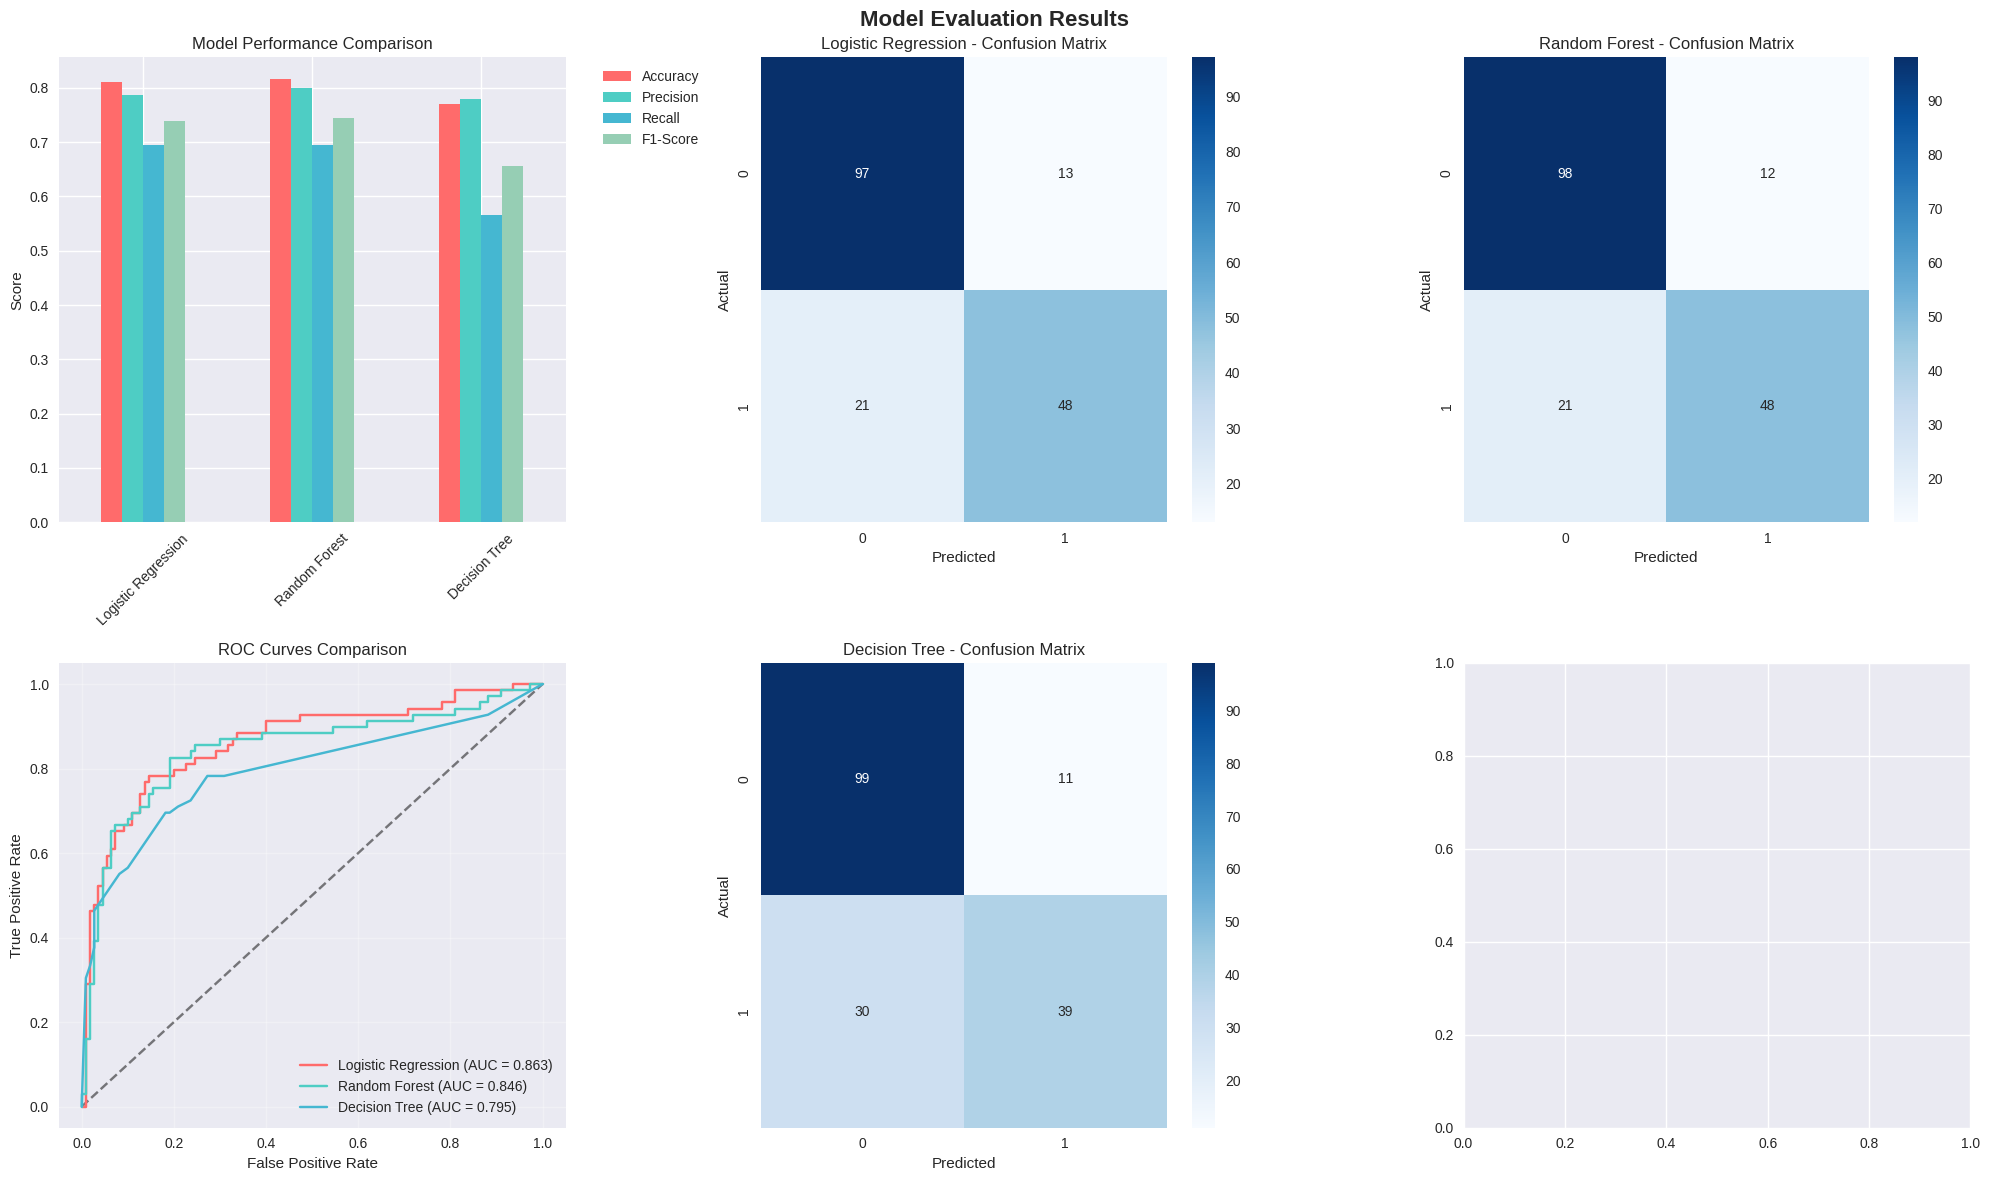

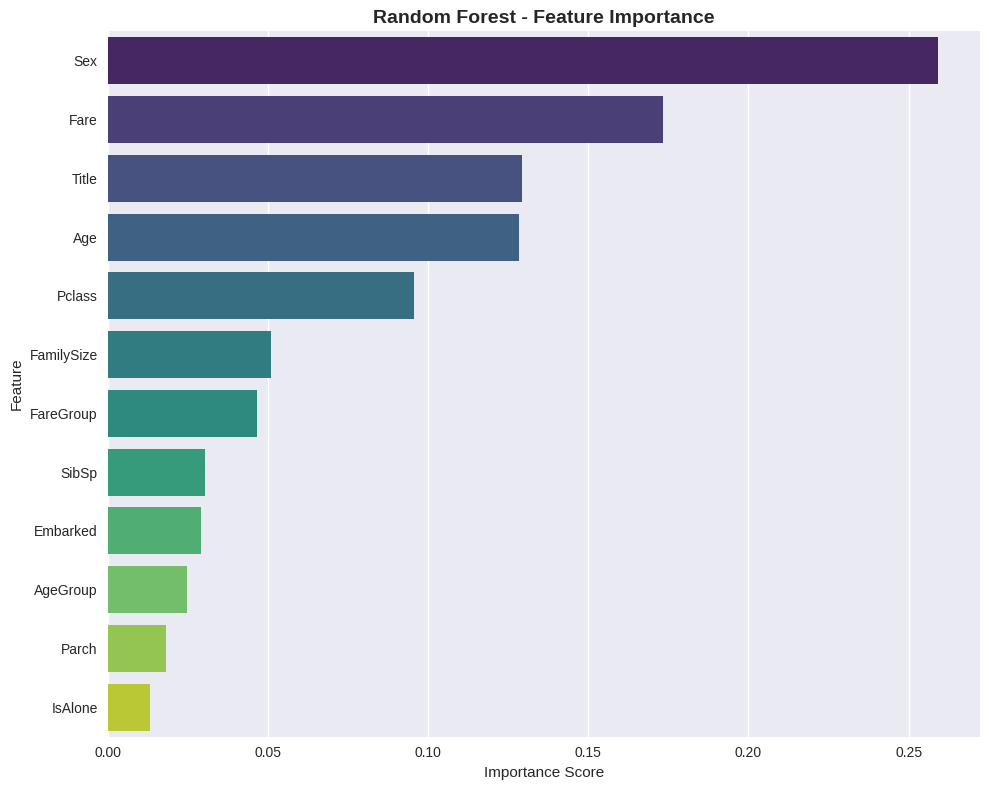

In [27]:
def evaluate_models(models, predictions, y_test, X_test, X_test_scaled):
    print("="*50)
    print("MODEL EVALUATION")
    print("="*50)

    results = {}

    for name, model in models.items():
        y_pred = predictions[name]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }

        print(f"\n{name} Results:")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")

    return results

def create_evaluation_plots(results, models, predictions, y_test, X_test, X_test_scaled):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Model Evaluation Results', fontsize=16, fontweight='bold')

    metrics_df = pd.DataFrame(results).T
    metrics_df.plot(kind='bar', ax=axes[0, 0], color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
    axes[0, 0].set_title('Model Performance Comparison')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].tick_params(axis='x', rotation=45)

    for idx, (name, model) in enumerate(models.items()):
        row, col = (idx // 2, (idx % 2) + 1)
        if row < 2:
            y_pred = predictions[name]
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col])
            axes[row, col].set_title(f'{name} - Confusion Matrix')
            axes[row, col].set_xlabel('Predicted')
            axes[row, col].set_ylabel('Actual')

    axes[1, 0].set_title('ROC Curves Comparison')
    axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)

    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    for idx, (name, model) in enumerate(models.items()):
        if hasattr(model, 'predict_proba'):
            X_test_data = X_test_scaled if name == 'Logistic Regression' else X_test
            y_proba = model.predict_proba(X_test_data)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            axes[1, 0].plot(fpr, tpr, color=colors[idx],
                          label=f'{name} (AUC = {roc_auc:.3f})')

    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_feature_importance(models, X_train):
    if 'Random Forest' in models:
        rf_model = models['Random Forest']
        feature_names = X_train.columns

        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': rf_model.feature_importances_
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
        plt.title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

results = evaluate_models(models, predictions, y_test, X_test, X_test_scaled)
create_evaluation_plots(results, models, predictions, y_test, X_test, X_test_scaled)
plot_feature_importance(models, X_train)

Final Prediction and Submission


Generating final predictions using Random Forest...
Predictions saved to 'titanic_predictions.csv'
Predicted survival rate: 36.60%

Generating final predictions using Logistic Regression...
Predictions saved to 'titanic_predictions.csv'
Predicted survival rate: 36.84%

Generating final predictions using Decision Tree...
Predictions saved to 'titanic_predictions.csv'
Predicted survival rate: 30.62%

Comparing predictions with sample submission:

Accuracy compared to sample submission: 0.8636


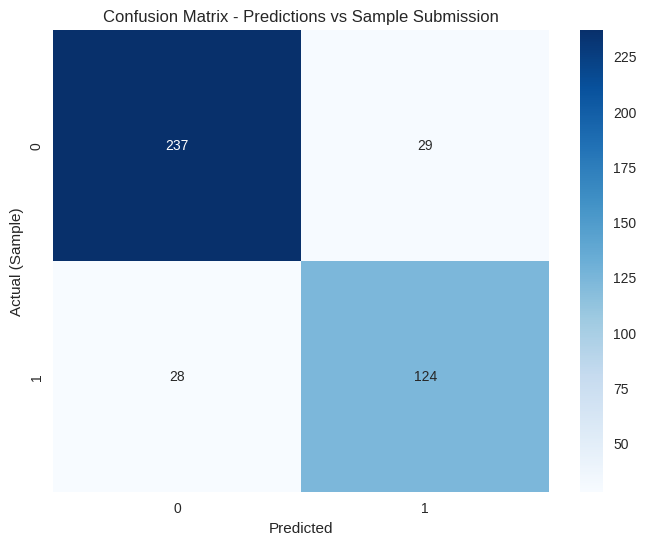


Accuracy compared to sample submission: 0.9378


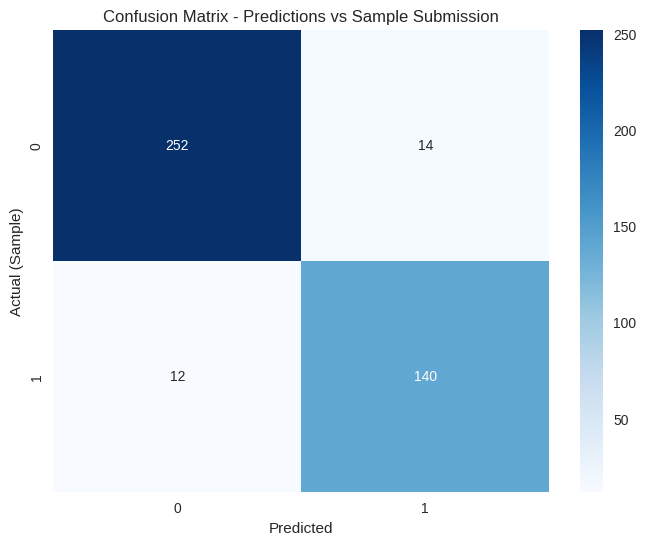


Accuracy compared to sample submission: 0.8660


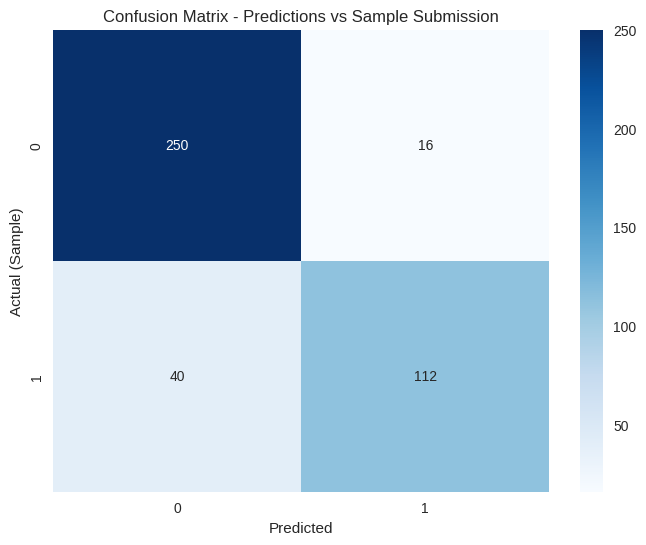


Model comparison with sample submission:
Random Forest: 0.8636
Logistic Regression: 0.9378
Decision Tree: 0.8660

Best performing model: Logistic Regression with accuracy: 0.9378


In [28]:
def generate_predictions(models, X_test_final, X_final_scaled, test_data, model_name='Random Forest'):
    print(f"\nGenerating final predictions using {model_name}...")

    if model_name not in models:
        print(f"Model {model_name} not found. Available models: {list(models.keys())}")
        return None

    model = models[model_name]

    X_final_data = X_final_scaled if model_name == 'Logistic Regression' else X_test_final

    final_predictions = model.predict(X_final_data)

    submission = pd.DataFrame({
        'PassengerId': test_data['PassengerId'],
        'Survived': final_predictions
    })

    submission.to_csv('titanic_predictions.csv', index=False)
    print(f"Predictions saved to 'titanic_predictions.csv'")
    print(f"Predicted survival rate: {final_predictions.mean():.2%}")

    return submission

def compare_with_sample_submission(submission, submission_data):
    merged = submission.merge(submission_data, on='PassengerId', suffixes=('_pred', '_actual'))
    accuracy = (merged['Survived_pred'] == merged['Survived_actual']).mean()
    print(f"\nAccuracy compared to sample submission: {accuracy:.4f}")

    cm = confusion_matrix(merged['Survived_actual'], merged['Survived_pred'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Predictions vs Sample Submission')
    plt.xlabel('Predicted')
    plt.ylabel('Actual (Sample)')
    plt.show()

    return accuracy

submission_rf = generate_predictions(models, X_test_final, X_final_scaled, test_data, 'Random Forest')
submission_lr = generate_predictions(models, X_test_final, X_final_scaled, test_data, 'Logistic Regression')
submission_dt = generate_predictions(models, X_test_final, X_final_scaled, test_data, 'Decision Tree')

print("\nComparing predictions with sample submission:")
accuracy_rf = compare_with_sample_submission(submission_rf, submission_data)
accuracy_lr = compare_with_sample_submission(submission_lr, submission_data)
accuracy_dt = compare_with_sample_submission(submission_dt, submission_data)

print(f"\nModel comparison with sample submission:")
print(f"Random Forest: {accuracy_rf:.4f}")
print(f"Logistic Regression: {accuracy_lr:.4f}")
print(f"Decision Tree: {accuracy_dt:.4f}")

best_model = max([('Random Forest', accuracy_rf), ('Logistic Regression', accuracy_lr), ('Decision Tree', accuracy_dt)], key=lambda x: x[1])
print(f"\nBest performing model: {best_model[0]} with accuracy: {best_model[1]:.4f}")

Complete Pipeline Runner

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚢 TITANIC SURVIVAL PREDICTION - COMPLETE PIPELINE")
print("="*60)

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission_data = pd.read_csv('gender_submission.csv')

print("✅ Data loaded successfully!")
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

print("\n📊 Quick Data Overview:")
print(f"Survival rate: {train_data['Survived'].mean():.2%}")
print(f"Missing values in Age: {train_data['Age'].isnull().sum()}")
print(f"Missing values in Embarked: {train_data['Embarked'].isnull().sum()}")

train_processed = train_data.copy()
test_processed = test_data.copy()

all_data = [train_processed, test_processed]

for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype(int)

    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                               'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in all_data:
    for title in dataset['Title'].unique():
        if pd.isna(title):
            continue
        for pclass in dataset['Pclass'].unique():
            mask = (dataset['Title'] == title) & (dataset['Pclass'] == pclass)
            median_age = dataset.loc[mask, 'Age'].median()
            if pd.isna(median_age):
                median_age = dataset['Age'].median()
            dataset.loc[mask & dataset['Age'].isna(), 'Age'] = median_age

embarked_mode = train_processed['Embarked'].mode()[0]
for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].fillna(embarked_mode)
    dataset['Fare'] = dataset['Fare'].fillna(dataset.groupby('Pclass')['Fare'].transform('median'))

for dataset in all_data:
    dataset['AgeGroup'] = pd.cut(dataset['Age'], bins=[0, 12, 18, 35, 60, 100],
                               labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    dataset['FareGroup'] = pd.qcut(dataset['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

categorical_features = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    combined_feature = pd.concat([train_processed[feature], test_processed[feature]], axis=0)
    le.fit(combined_feature.astype(str))

    train_processed[feature] = le

🚢 TITANIC SURVIVAL PREDICTION - COMPLETE PIPELINE
✅ Data loaded successfully!
Training data shape: (891, 12)
Test data shape: (418, 11)

📊 Quick Data Overview:
Survival rate: 38.38%
Missing values in Age: 177
Missing values in Embarked: 2


Interactive Titanic Survival Predictor

In [35]:

class SimpleTitanicPredictor:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.label_encoders = {}
        self.is_trained = False

    def quick_train(self, train_path='train.csv'):
        try:
            print("🚂 Quick training mode...")
            data = pd.read_csv(train_path)

            data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
            data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

            data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
            data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir'], 'Rare')
            data['Title'] = data['Title'].replace('Mlle', 'Miss')
            data['Title'] = data['Title'].replace('Ms', 'Miss')
            data['Title'] = data['Title'].replace('Mme', 'Mrs')

            data['Age'].fillna(data['Age'].median(), inplace=True)
            data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
            data['Fare'].fillna(data['Fare'].median(), inplace=True)

            data['AgeGroup'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 100],
                                    labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
            data['FareGroup'] = pd.qcut(data['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

            categorical_features = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']
            for feature in categorical_features:
                le = LabelEncoder()
                data[feature] = le.fit_transform(data[feature].astype(str))
                self.label_encoders[feature] = le

            features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
                       'FamilySize', 'IsAlone', 'Title', 'AgeGroup', 'FareGroup']

            X = data[features]
            y = data['Survived']

            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
            self.model.fit(X, y)

            self.is_trained = True
            print("✅ Quick training completed!")
            return True

        except Exception as e:
            print(f"❌ Training failed: {e}")
            return False

    def predict_passenger(self, pclass, sex, age, sibsp, parch, fare, embarked, title=None):
        if not self.is_trained:
            print("❌ Model not trained yet!")
            return None

        try:
            if title is None:
                if sex.lower() == 'male':
                    title = 'Mr'
                elif age < 18:
                    title = 'Miss'
                else:
                    title = 'Mrs'

            passenger_data = {
                'Pclass': pclass,
                'Sex': sex,
                'Age': age,
                'SibSp': sibsp,
                'Parch': parch,
                'Fare': fare,
                'Embarked': embarked,
                'Title': title,
                'FamilySize': sibsp + parch + 1,
                'IsAlone': 1 if (sibsp + parch + 1) == 1 else 0
            }

            if age <= 12:
                passenger_data['AgeGroup'] = 'Child'
            elif age <= 18:
                passenger_data['AgeGroup'] = 'Teen'
            elif age <= 35:
                passenger_data['AgeGroup'] = 'Adult'
            elif age <= 60:
                passenger_data['AgeGroup'] = 'Middle'
            else:
                passenger_data['AgeGroup'] = 'Senior'

            if fare <= 7.91:
                passenger_data['FareGroup'] = 'Low'
            elif fare <= 14.454:
                passenger_data['FareGroup'] = 'Medium'
            elif fare <= 31.0:
                passenger_data['FareGroup'] = 'High'
            else:
                passenger_data['FareGroup'] = 'VeryHigh'

            df = pd.DataFrame([passenger_data])

            categorical_features = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']
            for feature in categorical_features:
                if feature in self.label_encoders:
                    try:
                        df[feature] = self.label_encoders[feature].transform(df[feature].astype(str))
                    except:
                        df[feature] = 0

            features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
                       'FamilySize', 'IsAlone', 'Title', 'AgeGroup', 'FareGroup']

            X = df[features]

            prediction = self.model.predict(X)[0]
            probability = self.model.predict_proba(X)[0]

            return {
                'survived': bool(prediction),
                'survival_probability': round(probability[1] * 100, 1),
                'confidence': 'High' if max(probability) > 0.7 else 'Medium' if max(probability) > 0.6 else 'Low'
            }

        except Exception as e:
            print(f"❌ Prediction error: {e}")
            return None

def interactive_prediction():
    predictor = SimpleTitanicPredictor()

    if not predictor.quick_train():
        print("Cannot proceed without training data")
        return

    print("\n" + "="*60)
    print("🚢 INTERACTIVE TITANIC SURVIVAL PREDICTOR")
    print("="*60)
    print("Enter passenger details to predict survival chances")
    print("(Press Enter for default values)")

    while True:
        try:
            print("\n" + "-"*40)
            print("👤 Enter Passenger Information:")

            pclass = input("Passenger Class (1/2/3) [default: 3]: ").strip()
            pclass = int(pclass) if pclass else 3

            sex = input("Sex (male/female) [default: male]: ").strip().lower()
            sex = sex if sex in ['male', 'female'] else 'male'

            age = input("Age [default: 30]: ").strip()
            age = int(age) if age else 30

            sibsp = input("Number of siblings/spouses aboard [default: 0]: ").strip()
            sibsp = int(sibsp) if sibsp else 0

            parch = input("Number of parents/children aboard [default: 0]: ").strip()
            parch = int(parch) if parch else 0

            fare = input("Ticket fare [default: auto]: ").strip()
            if fare:
                fare = float(fare)
            else:
                fare_defaults = {1: 84.15, 2: 20.66, 3: 13.68}
                fare = fare_defaults.get(pclass, 13.68)

            embarked = input("Port of embarkation (S/C/Q) [default: S]: ").strip().upper()
            embarked = embarked if embarked in ['S', 'C', 'Q'] else 'S'

            print(f"\n📊 Predicting for:")
            print(f"  Class {pclass} {sex}, age {age}")
            print(f"  Family: {sibsp} siblings/spouses, {parch} parents/children")
            print(f"  Fare: ${fare:.2f}, Embarked at: {embarked}")

            result = predictor.predict_passenger(pclass, sex, age, sibsp, parch, fare, embarked)

            if result:
                status = "SURVIVED ✅" if result['survived'] else "DIED ❌"
                print(f"\n🎯 PREDICTION: {status}")
                print(f"📈 Survival Probability: {result['survival_probability']}%")
                print(f"🎪 Confidence Level: {result['confidence']}")

                if result['survival_probability'] > 70:
                    print("💪 High chance of survival!")
                elif result['survival_probability'] > 50:
                    print("⚖️  Moderate chance of survival")
                else:
                    print("⚠️  Low chance of survival")
            else:
                print("❌ Prediction failed")

            continue_pred = input("\nPredict another passenger? (y/n) [default: y]: ").strip().lower()
            if continue_pred == 'n':
                break

        except KeyboardInterrupt:
            print("\n👋 Goodbye!")
            break
        except Exception as e:
            print(f"❌ Error: {e}")
            continue

def run_sample_predictions():
    predictor = SimpleTitanicPredictor()

    if not predictor.quick_train():
        return

    print("\n" + "="*50)
    print("🎯 SAMPLE PREDICTIONS")
    print("="*50)

    samples = [
        (1, 'female', 29, 0, 0, 211.34, 'S', "First class woman"),
        (3, 'male', 22, 1, 0, 7.25, 'S', "Third class man with spouse"),
        (2, 'female', 35, 1, 2, 23.45, 'C', "Second class mother"),
        (1, 'male', 45, 0, 0, 50.0, 'S', "First class businessman"),
        (3, 'female', 8, 0, 2, 15.0, 'Q', "Third class child"),
    ]

    for pclass, sex, age, sibsp, parch, fare, embarked, description in samples:
        result = predictor.predict_passenger(pclass, sex, age, sibsp, parch, fare, embarked)

        if result:
            status = "SURVIVED" if result['survived'] else "DIED"
            print(f"\n👤 {description}:")
            print(f"   Class {pclass}, {sex}, age {age}, fare ${fare:.2f}")
            print(f"   🎯 {status} ({result['survival_probability']}% chance)")

if __name__ == "__main__":
    print("Choose mode:")
    print("1. Interactive Prediction")
    print("2. Sample Predictions")

    choice = input("\nEnter choice (1/2) [default: 2]: ").strip()

    if choice == '1':
        interactive_prediction()
    else:
        run_sample_predictions()

Choose mode:
1. Interactive Prediction
2. Sample Predictions

Enter choice (1/2) [default: 2]: 2
🚂 Quick training mode...
✅ Quick training completed!

🎯 SAMPLE PREDICTIONS

👤 First class woman:
   Class 1, female, age 29, fare $211.34
   🎯 SURVIVED (97.0% chance)

👤 Third class man with spouse:
   Class 3, male, age 22, fare $7.25
   🎯 DIED (10.3% chance)

👤 Second class mother:
   Class 2, female, age 35, fare $23.45
   🎯 SURVIVED (91.0% chance)

👤 First class businessman:
   Class 1, male, age 45, fare $50.00
   🎯 DIED (2.0% chance)

👤 Third class child:
   Class 3, female, age 8, fare $15.00
   🎯 SURVIVED (55.0% chance)
